In [973]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
ts.set_token('457a66c9299e50e9e0b2bf6c2f122bb24d560735f01b443158d1c85e') # 日线接口
pro = ts.pro_api()
# df = pro.daily(ts_code='000001.SH', start_date='20010701', end_date='20190923')
df = ts.pro_bar(ts_code='000300.SH', asset='I', start_date='20150701', end_date='20191201')
look_back=30
foresight=2


/Users/chaozhan/opt/anaconda3/envs/py375/lib/python3.7/site-packages/tushare/util/upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [974]:
df['trade_date'] = pd.to_datetime(df['trade_date'])
df['trade_date'] = df['trade_date'].map(lambda x:x.strftime('%Y-%m-%d'))
# df.set_index('trade_date', inplace=True)
df=df.sort_values(by='trade_date')
df=df.reset_index(drop=True) #重置索引
print(df.shape)
#降序


(1078, 11)


In [975]:
df['RSI'] = talib.RSI(df['close'], timeperiod = 9)
df['WILLR']= talib.WILLR(df['high'], df['low'].values, df['close'].values, 7)
df1=df.dropna()
df1 = df1.drop(['trade_date','ts_code','pre_close','change','pct_chg','vol'],axis=1) #删除
print(df1.shape)

(1069, 7)


In [976]:

train_test_split = int(df1.shape[0]*0.8)
df1=df1.values
print(df1.shape)
# df1_close=df1[:,0]
# df1=np.delete(df1,0,axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)) #不能使用一维的数据
# scaler1_close = MinMaxScaler(feature_range=(0, 1))
df1=scaler.fit_transform(df1)
# df1_close=scaler.fit_transform(df1_close)
# x_train=scaler.fit_transform(x_train)
# x_test=scaler.fit_transform(x_test)
# y_train=scaler.fit_transform(y_train)
# y_test==scaler.fit_transform(y_test)

(1069, 7)


In [977]:
x_pre_train=df1[:train_test_split,:]
x_pre_test=df1[train_test_split:,:]

In [978]:
def create_dataset(dataset, look_back, foresight):   
    X, Y = [], []
    for i in range(len(dataset)-look_back-foresight): 
        obs = dataset[i:(i+look_back),:] # Sequence of 7 stock prices as features forming an observation                                        
       # Append sequence
        X.append(obs)
       # Append stock price value occurring 4 time-steps into future
        Y.append(dataset[i + (look_back+foresight), 0]) 
    return np.array(X), np.array(Y)

In [979]:
x_train, y_train = create_dataset(x_pre_train, look_back, foresight)
x_test, y_test = create_dataset(x_pre_test, look_back, foresight)
print(x_train.shape,y_train.shape)
x_train

(823, 30, 7) (823,)


array([[[0.81919716, 0.86255219, 0.90104   , ..., 1.        ,
         0.41042898, 0.77576049],
        [0.72454997, 0.79100104, 0.80245828, ..., 0.84836814,
         0.34944768, 0.57937607],
        [0.74446822, 0.71326149, 0.77019221, ..., 0.6593866 ,
         0.3679707 , 0.62070465],
        ...,
        [0.59089949, 0.64726079, 0.64296091, ..., 0.40597706,
         0.28709713, 0.20959282],
        [0.47898292, 0.55982477, 0.55888321, ..., 0.40038417,
         0.19172511, 0.02123598],
        [0.27457197, 0.39051856, 0.36097585, ..., 0.41060564,
         0.07980335, 0.01061211]],

       [[0.72454997, 0.79100104, 0.80245828, ..., 0.84836814,
         0.34944768, 0.57937607],
        [0.74446822, 0.71326149, 0.77019221, ..., 0.6593866 ,
         0.3679707 , 0.62070465],
        [0.84481142, 0.76158264, 0.85435108, ..., 0.7058013 ,
         0.45857337, 0.82890777],
        ...,
        [0.47898292, 0.55982477, 0.55888321, ..., 0.40038417,
         0.19172511, 0.02123598],
        [0.2

In [980]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.layers.embeddings import Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('训练历史')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['训练集','验证集'], loc='upper right')
    plt.show()
# print(x_train.shape)
# x_train=x_train.reshape(x_train.shape[0],-1)
# x_test=x_test.reshape(x_test.shape[0],-1)
y_train=y_train.reshape(-1,1,1)  #seq2seq1需要三维矩阵
y_test=y_test.reshape(-1,1,1)  #seq2seq1需要三维矩阵
print(y_train.shape,y_test.shape)


(823, 1, 1) (182, 1, 1)


In [981]:
# model = Sequential()
# model.add(Flatten())
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=1,  activation='sigmoid'))
# model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
# train_history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=100,  verbose=2)



In [982]:
# min_epoch=train_history.history['loss'].index(min(train_history.history['loss'])) #求最小的epoch在哪个位置
# print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history.history['loss']))
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')
# scores = model.evaluate(x_test, y_test, verbose =1)
# print("测试集数据MSE为",scores[1])

In [983]:
# model1 = Sequential()
# model1.add(LSTM(128,  input_shape=(look_back, 7), dropout=0.1, recurrent_dropout=0.1))
# model1.add(Dense(units=256, activation='relu'))
# model1.add(Dropout(0.2))
# model1.add(Dense(1, activation='sigmoid'))
# model1.compile(loss='mse', optimizer='adam', metrics = ['mse']) 
# train_history1 = model1.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=100,  verbose=1)

latent_dim = 64 # LSTM hidden units
dropout = .2

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(look_back, 7)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, recurrent_dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(units=1,activation='sigmoid') # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model1.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          (None, 30, 7)        0                                            
__________________________________________________________________________________________________
input_112 (InputLayer)          (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_110 (LSTM)                 [(None, 64), (None,  18432       input_111[0][0]                  
__________________________________________________________________________________________________
lstm_111 (LSTM)                 [(None, None, 64), ( 16896       input_112[0][0]                  
                                                                 lstm_110[0][1]                   
          

In [984]:
batch_size = 80
epochs = 30

# # sample of series from train_enc_start to train_enc_end  
# encoder_input_data = get_time_block_series(series_array, date_to_index, 
#                                            train_enc_start, train_enc_end)[:first_n_samples]
# encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
# decoder_target_data = get_time_block_series(series_array, date_to_index, 
#                                             train_pred_start, train_pred_end)[:first_n_samples]
# decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# # lagged target series for teacher forcing
# decoder_input_data = np.zeros(decoder_target_data.shape)
# decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
# decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model1.compile(optimizer='adam', loss='mse')
train_history1 = model1.fit([x_train, y_train], y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Train on 658 samples, validate on 165 samples
Epoch 1/30
658/658 [==============================] - 18s 28ms/step - loss: 0.0455 - val_loss: 0.0425
Epoch 2/30
658/658 [==============================] - 0s 434us/step - loss: 0.0318 - val_loss: 0.0242
Epoch 3/30
658/658 [==============================] - 0s 423us/step - loss: 0.0236 - val_loss: 0.0131
Epoch 4/30
658/658 [==============================] - 0s 464us/step - loss: 0.0138 - val_loss: 0.0061
Epoch 5/30
658/658 [==============================] - 0s 461us/step - loss: 0.0117 - val_loss: 0.0042
Epoch 6/30
658/658 [==============================] - 0s 404us/step - loss: 0.0118 - val_loss: 0.0040
Epoch 7/30
658/658 [==============================] - 0s 426us/step - loss: 0.0092 - val_loss: 0.0044
Epoch 8/30
658/658 [==============================] - 0s 450us/step - loss: 0.0090 - val_loss: 0.0047
Epoch 9/30
658/658 [==============================] - 0s 450us/step - loss: 0.0081 - val_loss: 0.0042
Epoch 10/30
658/658 [===============

In [985]:
print(x_test.shape,y_test.shape)
print(x_test)

(182, 30, 7) (182, 1, 1)
[[[0.13932963 0.15444738 0.10764324 ... 0.03812779 0.48694948 0.72450241]
  [0.17852289 0.1407695  0.12948486 ... 0.09601564 0.6439263  0.98522981]
  [0.17895338 0.17637662 0.13333935 ... 0.07022432 0.64539992 0.9340781 ]
  ...
  [0.53682721 0.53930296 0.54511607 ... 0.4727105  0.86508593 0.75672092]
  [0.53095414 0.53438242 0.51630284 ... 0.28866809 0.84143961 0.730505  ]
  [0.58325703 0.54999764 0.55337224 ... 0.34246565 0.89707533 0.96397192]]

 [[0.17852289 0.1407695  0.12948486 ... 0.09601564 0.6439263  0.98522981]
  [0.17895338 0.17637662 0.13333935 ... 0.07022432 0.64539992 0.9340781 ]
  [0.16773369 0.18061026 0.1379163  ... 0.06496735 0.57874945 0.61721074]
  ...
  [0.53095414 0.53438242 0.51630284 ... 0.28866809 0.84143961 0.730505  ]
  [0.58325703 0.54999764 0.55337224 ... 0.34246565 0.89707533 0.96397192]
  [0.61215415 0.60464487 0.64689384 ... 0.59824163 0.92246585 0.8026559 ]]

 [[0.17895338 0.17637662 0.13333935 ... 0.07022432 0.64539992 0.9340781

最小的训练轮数是第 24 
最小的训练MSE为 0.002574251641459396
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          (None, 30, 7)        0                                            
__________________________________________________________________________________________________
input_112 (InputLayer)          (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_110 (LSTM)                 [(None, 64), (None,  18432       input_111[0][0]                  
__________________________________________________________________________________________________
lstm_111 (LSTM)                 [(None, None, 64), ( 16896       input_112[0][0]                  
                                                                

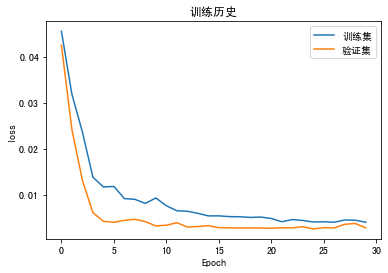

In [986]:
min_epoch=train_history1.history['val_loss'].index(min(train_history1.history['val_loss'])) #求最小的epoch在哪个位置
print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history1.history['val_loss']))
# min_epoch=np.where(np.array(train_history.history['val_loss'])==np.min(train_history.history['val_loss'],axis=0))#另外一种做法
# list(min_epoch)[0][0]
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')

print(model1.summary())
show_train_history(train_history1,'loss','val_loss')

# scores = model.evaluate(x_test, y_test, verbose =2)
# scores
scores = model1.evaluate([x_test, y_test], y_test, verbose =1)
print("测试集数据MSE为",scores)


In [987]:
# test_predict=model.predict(x_test)
# print(test_predict.shape,test_predict)
test_predict=model1.predict([x_test,y_test],batch_size=batch_size,verbose=1)
print(test_predict.shape,type(test_predict),test_predict)


182/182 [==============================] - 7s 36ms/step
(182, 1, 1) <class 'numpy.ndarray'> [[[0.5566194 ]]

 [[0.5739337 ]]

 [[0.5738069 ]]

 [[0.59525806]]

 [[0.6007602 ]]

 [[0.5640687 ]]

 [[0.5439006 ]]

 [[0.5437633 ]]

 [[0.54346675]]

 [[0.52718693]]

 [[0.52875775]]

 [[0.5546516 ]]

 [[0.5729353 ]]

 [[0.5778376 ]]

 [[0.58553505]]

 [[0.59465915]]

 [[0.5696005 ]]

 [[0.5543107 ]]

 [[0.5504925 ]]

 [[0.538359  ]]

 [[0.5688794 ]]

 [[0.6074226 ]]

 [[0.636549  ]]

 [[0.6635638 ]]

 [[0.6889544 ]]

 [[0.6990682 ]]

 [[0.71095526]]

 [[0.7190919 ]]

 [[0.7140424 ]]

 [[0.6987041 ]]

 [[0.68310285]]

 [[0.6970257 ]]

 [[0.70402926]]

 [[0.7106545 ]]

 [[0.7251177 ]]

 [[0.71099913]]

 [[0.6964966 ]]

 [[0.68953955]]

 [[0.6662486 ]]

 [[0.62273395]]

 [[0.6072209 ]]

 [[0.5911858 ]]

 [[0.5522091 ]]

 [[0.5376619 ]]

 [[0.5045033 ]]

 [[0.47329044]]

 [[0.47705626]]

 [[0.47161782]]

 [[0.4577215 ]]

 [[0.4785052 ]]

 [[0.5069185 ]]

 [[0.4994176 ]]

 [[0.47545946]]

 [[0.47

In [988]:
# test_predict=test_predict[0:440]
test_predict= test_predict.reshape(-1,1)
x_pre_test=x_pre_test[look_back+foresight:,1:7]  #x_pre_test=x_pre_test[:-10,1:7] ?????
x_pre_test=np.concatenate([test_predict,x_pre_test], axis=1)
test_predict=scaler.inverse_transform(x_pre_test)
print(x_pre_test.shape)

(182, 7)


In [989]:
print(test_predict.shape,test_predict)

(182, 7) [[ 3.70879547e+03  3.82285880e+03  3.85515560e+03 ...  3.31155617e+08
   8.54977319e+01 -1.55045211e+01]
 [ 3.73539249e+03  3.84114560e+03  3.84518200e+03 ...  3.59339153e+08
   7.69195643e+01 -3.13116449e+01]
 [ 3.73519765e+03  3.72140160e+03  3.77454310e+03 ...  3.49296691e+08
   5.35979050e+01 -9.68184047e+01]
 ...
 [ 3.79214421e+03  3.88342900e+03  3.88997830e+03 ...  1.07238822e+08
   4.34384728e+01 -6.29057417e+01]
 [ 3.78837714e+03  3.87790120e+03  3.88769030e+03 ...  8.70817889e+07
   4.06476306e+01 -7.37526886e+01]
 [ 3.79259185e+03  3.85718830e+03  3.86165840e+03 ...  1.16200557e+08
   3.43725712e+01 -7.90881278e+01]]


In [990]:
test_predict_1line=test_predict[:,0]
print(test_predict_1line.shape)
print(df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'].values)

(182,)
[3848.0903 3808.8497 3657.579  3729.9546 3755.3519 3724.1941 3698.4858
 3745.005  3851.7479 3833.9626 3835.4397 3836.8913 3833.8013 3742.8252
 3700.4388 3743.3878 3728.3953 3872.3412 3973.928  3971.2852 4022.1566
 4062.2309 4057.2286 4075.4301 4085.847  3997.5778 3988.6168 3975.5244
 4085.7891 4087.2398 4072.0753 4120.6078 4025.6109 4019.0053 4030.0887
 3941.816  3889.2748 3900.3339 3913.211  3684.6168 3720.6684 3667.4574
 3599.7001 3730.4513 3668.7255 3645.1503 3727.0923 3743.9635 3648.7609
 3617.7924 3666.7762 3649.3796 3583.9646 3593.9139 3637.1971 3672.2605
 3663.909  3641.1833 3629.7893 3632.0127 3598.4666 3597.105  3564.6778
 3610.7435 3719.2759 3691.0957 3685.3933 3654.8799 3654.8248 3667.6185
 3715.9381 3828.5183 3833.9383 3841.2659 3801.3098 3794.331  3834.8172
 3825.5873 3935.8116 3937.1691 3893.5341 3873.1019 3893.2025 3802.7897
 3793.1297 3786.739  3785.221  3808.7311 3824.1878 3806.8449 3804.6384
 3768.4019 3807.9551 3781.6832 3789.9135 3819.8325 3851.0665 3858.5688

In [991]:
df.shape[0]-test_predict_1line.shape[0]

896

In [992]:
backtest = pd.DataFrame(test_predict_1line,columns=['close_predict'])
backtest['close'] = df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'].values  #同一天，从后面测试集开始
backtest['trade_date'] = df.loc[df.shape[0]-test_predict_1line.shape[0]:,'trade_date'].values
# backtest = pd.DataFrame(test_predict_1line , df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'],columns=['close_predict','close'])

In [993]:
df[df['close']==backtest['close'][0]].trade_date

896    2019-03-06
Name: trade_date, dtype: object

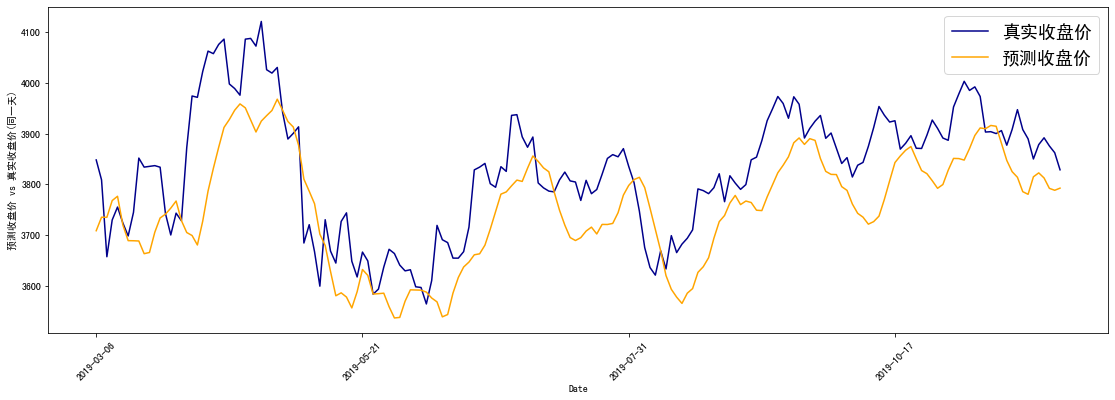

In [994]:
plt.figure(figsize = (19,6))
plt.plot(range(backtest.shape[0]),backtest['close'],color='darkblue',label='真实收盘价')
plt.plot(range(backtest.shape[0]),backtest['close_predict'],color='orange',label='预测收盘价')
plt.xticks(range(0,backtest.shape[0],50),backtest['trade_date'][::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('预测收盘价 vs 真实收盘价(同一天)')
plt.legend(fontsize=18)
plt.show()

In [997]:
backtest[str('close_'+str(foresight)+'_day_before')]=backtest['close'].shift(-foresight)
backtest.set_index('trade_date', drop= True, inplace = False)
# print(backtest.loc[0,'trade_date'])
# df1.loc['2017-02-03':'2017-02-06']
backtest.dropna(inplace=True)
# print(backtest)


In [998]:
backtest['buy']=np.where(backtest['close_predict']>backtest['close_'+str(foresight)+'_day_before'],1,0)

True